In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle

import mlrfit as mf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

#  Matrix definition

In [3]:
rank = 28
balanced_partition = False
kerns =  {"exp2": lambda r: np.exp(-r**2),\
          "exp1": lambda r: np.exp(-r),\
          "quad": lambda r: np.power((1 + r**2), -2),\
          "inv_quad": lambda r: np.power((1 + r**2), -1)}

kern_type = "quad"
mtype  = "radkern_%s_allL_unbal"%kern_type

d = 3
sigma = 0.9
La = 3

m = n = 3000 #5000
A, Dist = mf.radial_kernel_matrix(d, sigma, n, La, kerns[kern_type])

# with open("outputs/matrix_radkern_quad_allL_r28_5000_d3.pickle", "rb") as f:
#        A1 = pickle.load(f)
# print(f"{mf.rel_diff(A, A1)=}, {np.allclose(A, A1)=}")

symm = np.allclose(A, A.T) if m==n else False
num_levels = int(np.ceil(np.log2(min(m, n))) + 1)

(array([ 184002,  552043,  918471, 1285673, 1653453, 2020104, 2386254]), array([6.73070112e-04, 2.86291170e-01, 5.71909270e-01, 8.57527370e-01,
       1.14314547e+00, 1.42876357e+00, 1.71438167e+00, 1.99999977e+00]))


In [4]:
A.min(), A.mean(), A.max(), 1.*(A>1e-6).sum()/A.size

(0.030836346019870967, 0.22903893242469725, 2.999976510155209, 1.0)

In [5]:
U, Vt, sigmas = mf.frob_low_rank(A)
frob_losses = np.zeros(m)
normalization = np.linalg.norm(A, ord='fro')
# assert np.allclose(normalization, ((sigmas**2).sum())**0.5)
sigmas2 = (sigmas**2)[::-1]
frob_losses = np.concatenate([(np.cumsum(sigmas2)**0.5)[::-1][1:] / normalization, np.array([0])])

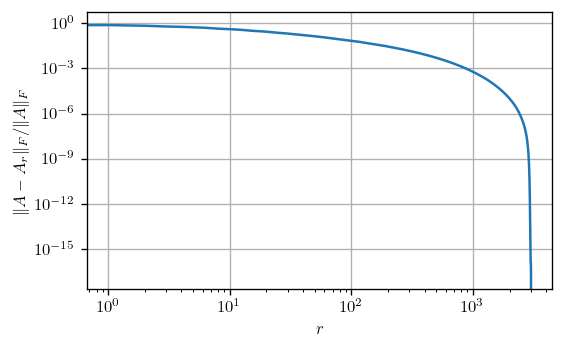

In [6]:
mf.plot_frob_error_rank(frob_losses)

In [7]:
eps_ff = 1e-2
eps = 1e-3

In [8]:
method = 'bcd'
svds_v0 = True
max_iters_ff = 2
max_iters = 3*10**3
grref_max_iters = 5000
PSD = False
refined = True
symm = np.allclose(A, A.T) if m==n else False
print(f"{symm=}")

filename = "%s_r%d_%d"%(mtype, rank, n)

symm=False


# Rank allocation + spectral partitioning + greedy refinement

In [9]:
info = {} 
hparts = {}

In [10]:
# LR
hpart = mf.random_hpartition(m, n, num_levels=1, symm=symm, perm=False)
B1, C1 = mf.single_level_factor_fit(A, np.array([rank]), hpart, level=0, symm=symm, PSD=PSD)[:2]
info['LR'] = {'loss':[mf.rel_diff(B1 @C1.T, den=A)]}
print(info['LR']['loss'][0])

0.22677686464323563


In [11]:
# LR+D fitting
hpart = mf.random_hpartition(m, n, level_list=[0, int(np.log2(m))+1], symm=symm, perm=False)
assert hpart['rows']['lk'][1].size == min(m,n)+1
ranks = np.array([rank-1, 1])
hat_A = mf.MLRMatrix(hpart=hpart, ranks=ranks)
start_time = time.time()
fa_losses = hat_A.factor_fit(A, ranks, hat_A.hpart, method=method, eps_ff=eps_ff/10000, \
                                  freq=100, svds_v0=svds_v0,\
                                  printing=False, max_iters_ff=max_iters, symm=symm, warm_start=False)
fa_time = time.time()-start_time
info['LR+D'] = {'loss':fa_losses, 'time':fa_time}
print(f"{fa_losses[-1]=} {len(fa_losses)} time={fa_time:.3f}")

/Users/parshakova.tanya/Documents/projects/MLR_Matrices/mlr_fitting_private/mlrfit/utils.py:410: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


fa_losses[-1]=0.23191906883895003 4 time=4.950


In [12]:
num_levels = int(np.ceil(np.log2(min(m,n)))+1)

In [13]:
# uniform rank initialization + spectral hierarchy + rank allocation
ranks = mf.uniform_ranks(rank, num_levels) 
print(ranks)
hat_A = mf.MLRMatrix()
start_time = time.time()
td_losses, _ = hat_A.hpartition_topdown(A, ranks, eps_ff=eps_ff, symm=symm, max_iters_ff=1, \
                                        balanced=balanced_partition, PSD=PSD, grref_max_iters=grref_max_iters)
td_time = time.time()-start_time
print(f"{td_losses[-1]=} time={td_time:.3f}")
start_time = time.time()
ra_losses, epochs, ranks_history_uni = hat_A.rank_alloc(A, ranks, hat_A.hpart, freq=1,\
                        eps=eps, eps_ff=eps_ff, max_iters=max_iters, PSD=PSD, symm=symm,\
                        max_iters_ff=max_iters_ff, warm_start=True)
ra_time = time.time()-start_time
info['MLR uniform'] = {'loss':ra_losses, 'td_time':td_time, 'ra_time':ra_time, 'epochs':epochs}
print(f"td+ra time={ra_time:.3f}")
assert np.allclose(ra_losses[0], td_losses[-1]), print(ra_losses[0], td_losses[-1])

hparts["u"] = hat_A.hpart

[3 3 2 2 2 2 2 2 2 2 2 2 2]
* level=0, losses[0]=0.702, losses[-1]=0.702, len(losses)=2, [3]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


* level=1, losses[0]=0.532, losses[-1]=0.529, len(losses)=2, [3 3]
* level=2, losses[0]=0.446, losses[-1]=0.442, len(losses)=2, [3 3 2]
* level=3, losses[0]=0.382, losses[-1]=0.378, len(losses)=2, [3 3 2 2]
* level=4, losses[0]=0.331, losses[-1]=0.327, len(losses)=2, [3 3 2 2 2]
* level=5, losses[0]=0.300, losses[-1]=0.297, len(losses)=2, [3 3 2 2 2 2]
* level=6, losses[0]=0.282, losses[-1]=0.280, len(losses)=2, [3 3 2 2 2 2 2]
* level=7, losses[0]=0.272, losses[-1]=0.271, len(losses)=2, [3 3 2 2 2 2 2 2]
* level=8, losses[0]=0.265, losses[-1]=0.264, len(losses)=2, [3 3 2 2 2 2 2 2 2]
* level=9, losses[0]=0.260, losses[-1]=0.259, len(losses)=2, [3 3 2 2 2 2 2 2 2 2]
* level=10, losses[0]=0.256, losses[-1]=0.255, len(losses)=2, [3 3 2 2 2 2 2 2 2 2 2]
* level=11, losses[0]=0.253, losses[-1]=0.252, len(losses)=2, [3 3 2 2 2 2 2 2 2 2 2 2]
num_blocks=1046
* level=12, losses[0]=0.250, losses[-1]=0.250, len(losses)=2, [3 3 2 2 2 2 2 2 2 2 2 2 2]
level=12, loss=0.24967377047770528
td_losses[

In [14]:
# bottom rank initialization + spectral hierarchy + rank allocation
ranks = np.array((num_levels-1)*[0]+[rank]) 
print(ranks)
hat_A = mf.MLRMatrix(debug=False)
start_time = time.time()
td_losses, _ = hat_A.hpartition_topdown(A, ranks, eps_ff=eps_ff, symm=symm, max_iters_ff=1, \
                                        balanced=balanced_partition, PSD=PSD, grref_max_iters=grref_max_iters)
td_time = time.time()-start_time
print(f"{td_losses[-1]=} time={td_time:.3f}")
start_time = time.time()
ra_losses, epochs, ranks_history_bottom = hat_A.rank_alloc(A, ranks, hat_A.hpart, freq=1,\
                        eps=eps, eps_ff=eps_ff, max_iters=max_iters, PSD=PSD, symm=symm,\
                        max_iters_ff=max_iters_ff, warm_start=True)
ra_time = time.time()-start_time
info['MLR bottom'] = {'loss':ra_losses, 'td_time':td_time, 'ra_time':ra_time, 'epochs':epochs}
print(f"td+ra time={ra_time:.3f}")
assert np.allclose(ra_losses[0], td_losses[-1]), print(ra_losses[0], td_losses[-1])

hparts["b"] = hat_A.hpart

[ 0  0  0  0  0  0  0  0  0  0  0  0 28]
* level=0, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0]
* level=1, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0]
* level=2, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0]
* level=3, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0]
* level=4, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0]
* level=5, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0]
* level=6, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0 0]
* level=7, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0 0 0]
* level=8, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0 0 0 0]
* level=9, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0 0 0 0 0]
* level=10, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0 0 0 0 0 0]
* level=11, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0 0 0 0 0 0 0]
num_blocks=1872
* level=12, losses[0]=0.991, 

In [15]:
# top rank initialization + spectral hierarchy + rank allocation
ranks = np.array([rank]+(num_levels-1)*[0])
print(ranks)
hat_A = mf.MLRMatrix()
start_time = time.time()
td_losses, _ = hat_A.hpartition_topdown(A, ranks, eps_ff=eps_ff, symm=symm, max_iters_ff=1, \
                                        balanced=balanced_partition, PSD=PSD, grref_max_iters=grref_max_iters)
td_time = time.time()-start_time
print(f"{td_losses[-1]=} time={td_time:.3f}")
start_time = time.time()
ra_losses, epochs, ranks_history_top = hat_A.rank_alloc(A, ranks, hat_A.hpart, freq=1,\
                        eps=eps, eps_ff=eps_ff, max_iters=max_iters, PSD=PSD, symm=symm,\
                        max_iters_ff=max_iters_ff, warm_start=True)
ra_time = time.time()-start_time
info['MLR top'] = {'loss':ra_losses, 'td_time':td_time, 'ra_time':ra_time, 'epochs':epochs}
print(f"td+ra time={ra_time:.3f}")
assert np.allclose(ra_losses[0], td_losses[-1]), print(ra_losses[0], td_losses[-1])

hparts["t"] = hat_A.hpart

[28  0  0  0  0  0  0  0  0  0  0  0  0]
* level=0, losses[0]=0.227, losses[-1]=0.227, len(losses)=2, [28]
* level=1, losses[0]=0.227, losses[-1]=0.227, len(losses)=2, [28  0]
* level=2, losses[0]=0.227, losses[-1]=0.227, len(losses)=2, [28  0  0]
* level=3, losses[0]=0.227, losses[-1]=0.227, len(losses)=2, [28  0  0  0]
* level=4, losses[0]=0.227, losses[-1]=0.227, len(losses)=2, [28  0  0  0  0]
* level=5, losses[0]=0.227, losses[-1]=0.227, len(losses)=2, [28  0  0  0  0  0]
* level=6, losses[0]=0.227, losses[-1]=0.227, len(losses)=2, [28  0  0  0  0  0  0]
* level=7, losses[0]=0.227, losses[-1]=0.227, len(losses)=2, [28  0  0  0  0  0  0  0]
* level=8, losses[0]=0.227, losses[-1]=0.227, len(losses)=2, [28  0  0  0  0  0  0  0  0]
* level=9, losses[0]=0.227, losses[-1]=0.227, len(losses)=2, [28  0  0  0  0  0  0  0  0  0]
* level=10, losses[0]=0.227, losses[-1]=0.227, len(losses)=2, [28  0  0  0  0  0  0  0  0  0  0]
* level=11, losses[0]=0.227, losses[-1]=0.227, len(losses)=2, [28  

In [16]:
# mf.plot_loss_all_info(info, figsize=(7, 5), dpi=120, logscale=False, hline=True, ylim=None, filename='')

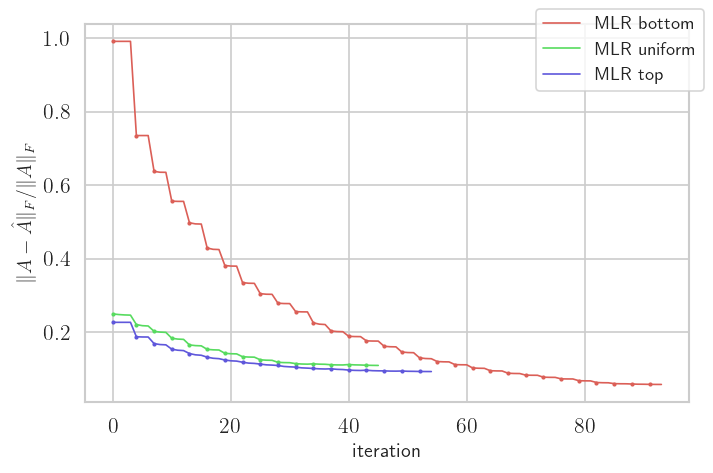

In [17]:
mf.plot_loss_all_info(info, labels=['MLR bottom', 'MLR uniform', 'MLR top'], figsize=(6, 4), dpi=120, \
                        logscale=False, hline=False, ylim=None, filename='')

In [18]:
for i, algo in enumerate(info.keys()):
    print(f"{algo:14s} {info[algo]['loss'][-1]}")

LR             0.22677686464323563
LR+D           0.23191906883895003
MLR uniform    0.10954939624262505
MLR bottom     0.05785881776020821
MLR top        0.09292677438055731


In [19]:
# with open('outputs/info_%s.pickle'%filename, 'wb') as handle:
#     pickle.dump(info, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('outputs/hparts_%s.pickle'%filename, 'wb') as handle:
    pickle.dump(hparts, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
rh_top = np.stack(ranks_history_top, axis=0)
rh_bot = np.stack(ranks_history_bottom, axis=0)
rh_uni = np.stack(ranks_history_uni, axis=0)

# with open('outputs/ranks_%s.pickle'%filename, 'wb') as handle:
#     pickle.dump([rh_bot, rh_uni, rh_top], handle, protocol=pickle.HIGHEST_PROTOCOL)

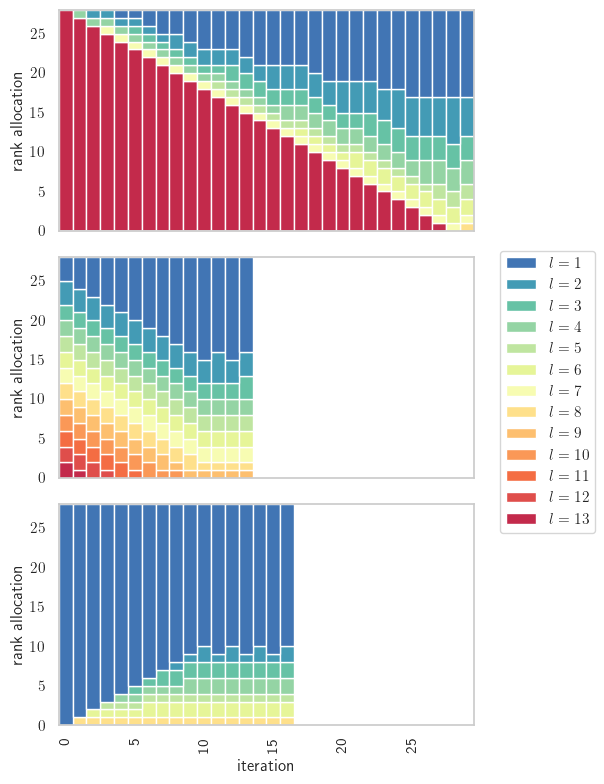

In [21]:
mf.plot_ra_evolution_col([rh_bot, rh_uni, rh_top], dpi=100, figsize=(5, 8))  #filename="plots/ra_%s.pdf"%filename)